# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [16]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 104, 104, 3))
    return array

    

In [17]:
def display(array1, array2, n):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    indices = np.random.randint(len(array1), size=n)
    images1 = np.asarray(array1)[indices, :]
    images2 = np.asarray(array2)[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
999 photos


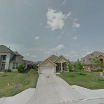

In [18]:
images = []
wb_images = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/work 6/street_data")))
n = len(imagePaths)
for i in range(n):
	if i %10 == 0:
		print(i)	
	image = cv2.imread(imagePaths[i]) # загружаем изображение
	try:
		image = cv2.resize(image, (104, 104))
		images.append(image) # добавляем в список
		gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		gray3 = np.zeros_like(image)
		gray3[:,:,0] = gray1
		gray3[:,:,1] = gray1
		gray3[:,:,2] = gray1
		wb_images.append(gray3)
	except Exception as e:
		print(e)
		print('photo not processed',imagePaths[i])
print(i, 'photos')
cv2_imshow(images[0])

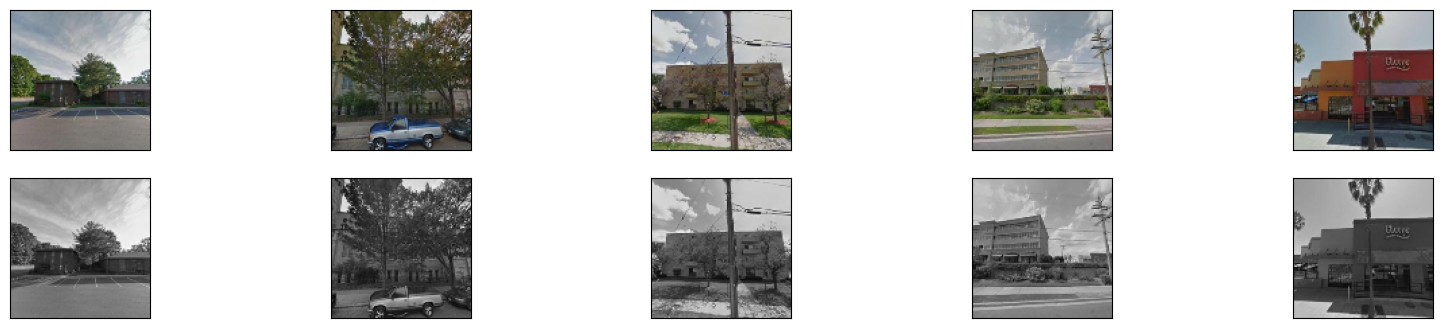

In [24]:
display(images, wb_images,5)

In [25]:
input = layers.Input(shape=(104, 104, 3))
# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)


from keras import optimizers

optimizer = optimizers.Adam(0.001)
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse', 'accuracy'])
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 104, 104, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 104, 104, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 52, 52, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 104, 104, 32)     9248      
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 104, 104, 3)       867       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable

In [26]:
from sklearn.model_selection import train_test_split
n_images = preprocess(np.asarray(images))
n_wb_images = preprocess(np.asarray(wb_images))

X_train, X_test, y_train, y_test = train_test_split(n_wb_images, n_images, test_size=0.2, random_state=0)

autoencoder.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, y_test),
)

Epoch 1/1000
7/7 [==============================] - 1s 143ms/step - loss: 0.0421 - mse: 0.0421 - accuracy: 0.3679 - val_loss: 0.0394 - val_mse: 0.0394 - val_accuracy: 0.3108
Epoch 2/1000
7/7 [==============================] - 1s 78ms/step - loss: 0.0401 - mse: 0.0401 - accuracy: 0.2961 - val_loss: 0.0376 - val_mse: 0.0376 - val_accuracy: 0.2618
Epoch 3/1000
7/7 [==============================] - 1s 77ms/step - loss: 0.0377 - mse: 0.0377 - accuracy: 0.3017 - val_loss: 0.0344 - val_mse: 0.0344 - val_accuracy: 0.3667
Epoch 4/1000
7/7 [==============================] - 1s 76ms/step - loss: 0.0336 - mse: 0.0336 - accuracy: 0.3829 - val_loss: 0.0293 - val_mse: 0.0293 - val_accuracy: 0.3186
Epoch 5/1000
7/7 [==============================] - 1s 77ms/step - loss: 0.0276 - mse: 0.0276 - accuracy: 0.3190 - val_loss: 0.0224 - val_mse: 0.0224 - val_accuracy: 0.2710
Epoch 6/1000
7/7 [==============================] - 1s 79ms/step - loss: 0.0199 - mse: 0.0199 - accuracy: 0.3522 - val_loss: 0.0146 - 

7/7 [==============================] - 0s 19ms/step


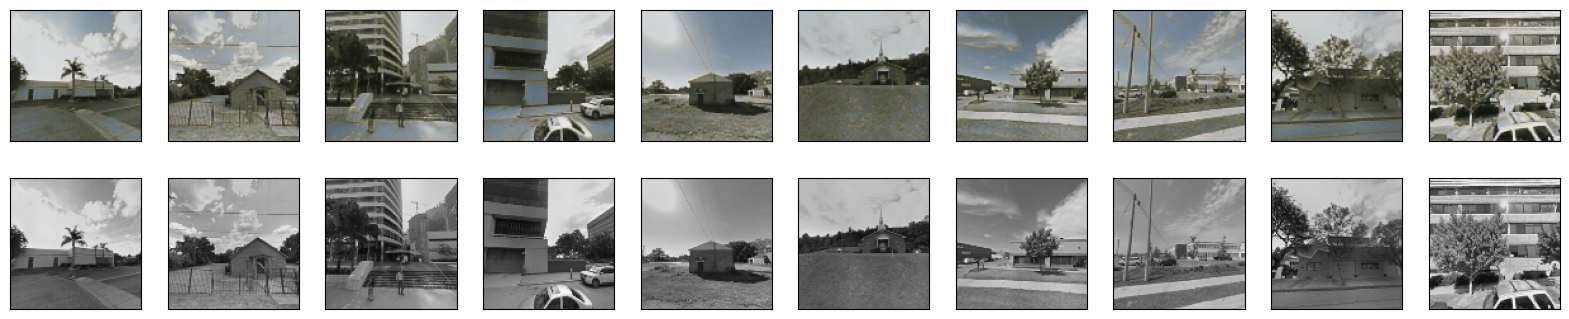

In [34]:
predictions = autoencoder.predict(X_test)
display(predictions, X_test, 10)

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from skimage.color import rgb2gray


def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(rgb2gray(image1).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rgb2gray(image2).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np

# загрузка данных
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# выбор изображений одного типа
class_idx = 0  # индекс выбранного класса
train_images_class = train_images[train_labels[:,0]==class_idx]
test_images_class = test_images[test_labels[:,0]==class_idx]

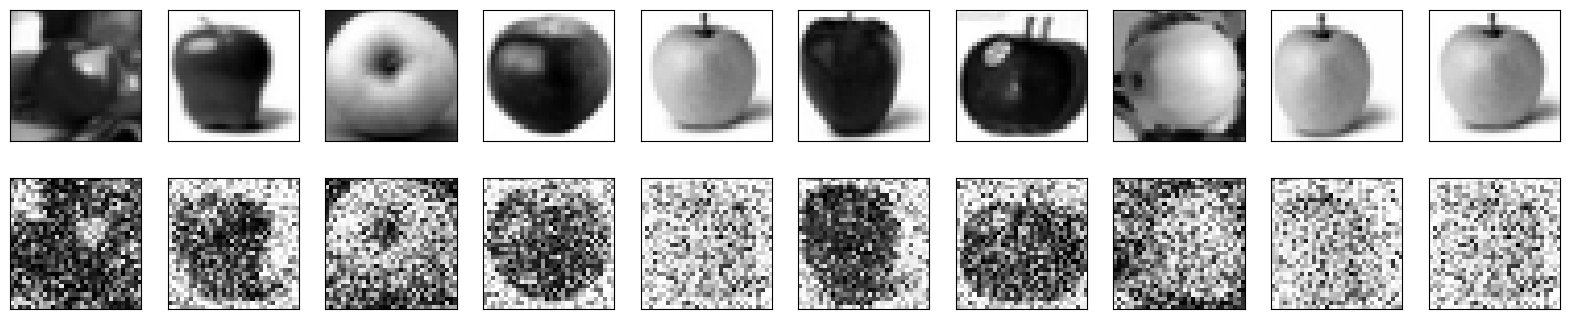

In [21]:
# Нормализация и изменение формы данных
train_data = preprocess(train_images_class)
test_data = preprocess(test_images_class)

# Создание копии данных с добавленным шумом
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Отображение данных выборки и его версии с добавленным шумом
display(train_data, noisy_train_data)

In [22]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 32)       9248

In [27]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=1000,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, noisy_test_data),
)

Epoch 1/1000
4/4 [==============================] - 6s 821ms/step - loss: 0.6926 - accuracy: 0.3268 - val_loss: 0.6903 - val_accuracy: 0.4696
Epoch 2/1000
4/4 [==============================] - 2s 518ms/step - loss: 0.6867 - accuracy: 0.7113 - val_loss: 0.6847 - val_accuracy: 0.5155
Epoch 3/1000
4/4 [==============================] - 2s 508ms/step - loss: 0.6758 - accuracy: 0.7626 - val_loss: 0.6780 - val_accuracy: 0.5205
Epoch 4/1000
4/4 [==============================] - 2s 501ms/step - loss: 0.6673 - accuracy: 0.7634 - val_loss: 0.6789 - val_accuracy: 0.5207
Epoch 5/1000
4/4 [==============================] - 2s 503ms/step - loss: 0.6598 - accuracy: 0.7636 - val_loss: 0.6702 - val_accuracy: 0.5207
Epoch 6/1000
4/4 [==============================] - 3s 754ms/step - loss: 0.6489 - accuracy: 0.7628 - val_loss: 0.6656 - val_accuracy: 0.5189
Epoch 7/1000
4/4 [==============================] - 4s 908ms/step - loss: 0.6307 - accuracy: 0.7580 - val_loss: 0.6665 - val_accuracy: 0.5116
Epoch 

4/4 [==============================] - 0s 55ms/step


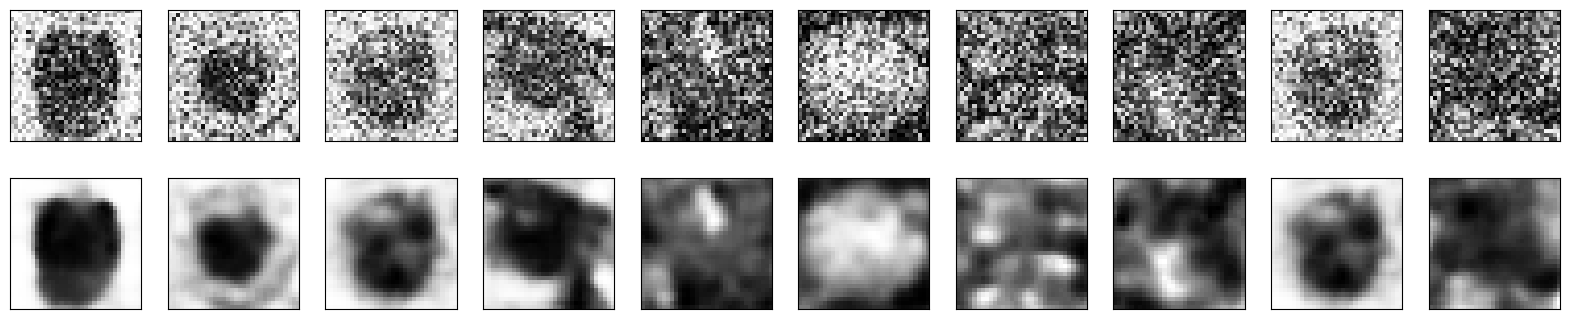

In [28]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

In [12]:
autoencoder.save('/content/drive/MyDrive/work 6/save 6.2.h5')

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (аскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого нужно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [4]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 104, 104, 3))
    return array

1000
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
999 photos


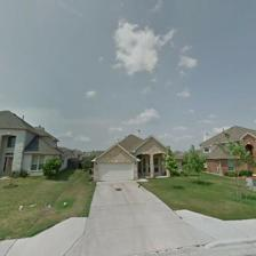

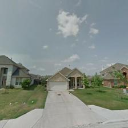

In [5]:
images256 = []
images128 = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/work 6/street_data")))

n = len(imagePaths)
print(n)
for i in range(n):
	if i % 10 == 0:
		print(i)	
	image = cv2.imread(imagePaths[i])
	try:
		images256.append(cv2.resize(image, (256, 256)))
		images128.append(cv2.resize(image, (128, 128)))
	except Exception as e:
		print(e)
		print('photo not processed',imagePaths[i])
print(i, 'photos')
cv2_imshow(images256[0])
cv2_imshow(images128[0])

In [6]:
input = layers.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

from keras import optimizers

optimizer = optimizers.Adam(0.0001)
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse', 'accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 64)     36928     
 ranspose)                                                       
                                                             

In [7]:
def preprocess(array, n):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), n, n, 3))
    return array

In [8]:
    from sklearn.model_selection import train_test_split

print(np.asarray(images128).shape, np.asarray(images256).shape)
images128 = preprocess(np.asarray(images128), 128)
images256 = preprocess(np.asarray(images256), 256)

X_train, X_test, y_train, y_test = train_test_split(images128, images256, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1000, 128, 128, 3) (1000, 256, 256, 3)
(800, 128, 128, 3) (200, 128, 128, 3) (800, 256, 256, 3) (200, 256, 256, 3)


In [9]:
autoencoder.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, y_test),
)

Epoch 1/50
25/25 [==============================] - 18s 232ms/step - loss: 0.0433 - mse: 0.0433 - accuracy: 0.3566 - val_loss: 0.0414 - val_mse: 0.0414 - val_accuracy: 0.3516
Epoch 2/50
25/25 [==============================] - 5s 195ms/step - loss: 0.0424 - mse: 0.0424 - accuracy: 0.3738 - val_loss: 0.0402 - val_mse: 0.0402 - val_accuracy: 0.3641
Epoch 3/50
25/25 [==============================] - 5s 202ms/step - loss: 0.0403 - mse: 0.0403 - accuracy: 0.3850 - val_loss: 0.0373 - val_mse: 0.0373 - val_accuracy: 0.3608
Epoch 4/50
25/25 [==============================] - 5s 193ms/step - loss: 0.0363 - mse: 0.0363 - accuracy: 0.3732 - val_loss: 0.0325 - val_mse: 0.0325 - val_accuracy: 0.3489
Epoch 5/50
25/25 [==============================] - 5s 196ms/step - loss: 0.0298 - mse: 0.0298 - accuracy: 0.4194 - val_loss: 0.0247 - val_mse: 0.0247 - val_accuracy: 0.4670
Epoch 6/50
25/25 [==============================] - 5s 194ms/step - loss: 0.0207 - mse: 0.0207 - accuracy: 0.4821 - val_loss: 0.0

25/25 [==============================] - 2s 73ms/step
(128, 128, 3) (256, 256, 3)


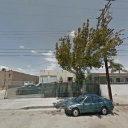

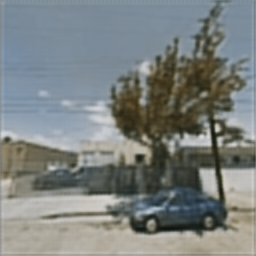

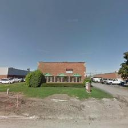

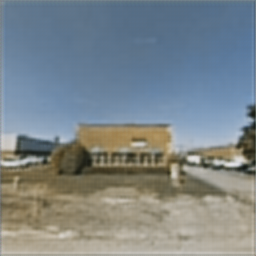

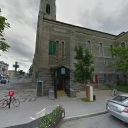

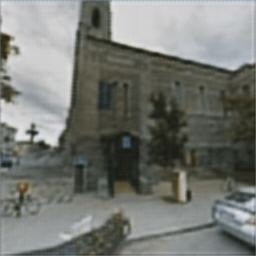

In [10]:
predictions = autoencoder.predict(X_train)
print(X_train[0].shape,predictions[0].shape)
for i in range(3):
  cv2_imshow(X_train[i]*255.0)
  cv2_imshow(predictions[i]*255.0)

In [11]:
autoencoder.save('/content/drive/MyDrive/work 6/save 6.3.h5')